In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style

import time

import cv2
from wavelets import WaveletAnalysis

In [2]:
Scenario_list = os.listdir('./Scenario')
Scenario_list

['Good_15s_HeavyOil_5s.npy',
 'Good_15s_Punch_5s.npy',
 'Good_15s_ScrappedWire_5s.npy',
 'Good_15s_DieChip_5s.npy',
 'Good_15s_DieInternal_5s.npy',
 'Good_15s_Pin_5s.npy']

In [3]:
Data = np.load('./Scenario/' + Scenario_list[0])

In [4]:
%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'

<IPython.core.display.Javascript object>


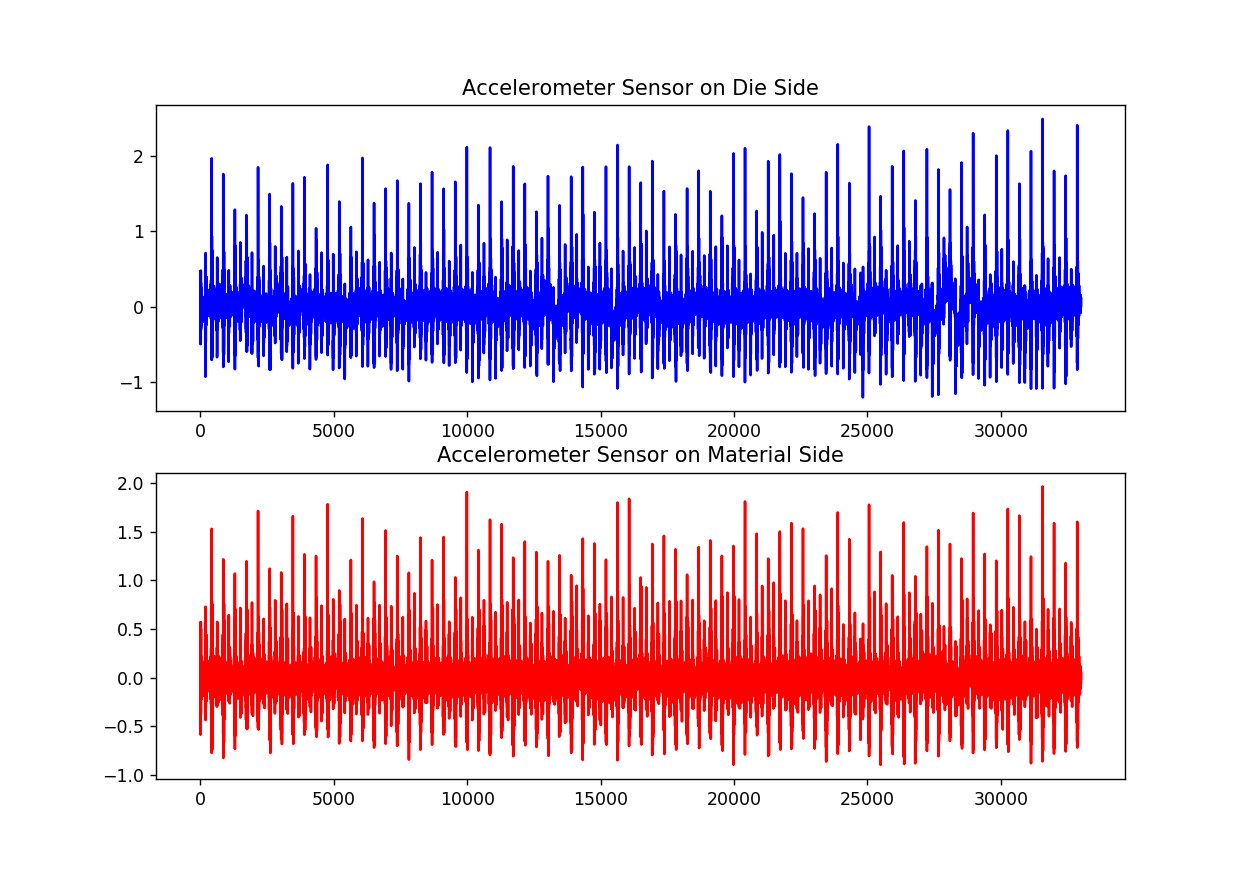

In [5]:
# style.use('fivethirtyeight')

fig = plt.figure(figsize = (10, 7))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

def Sec_to_M_S_ms(sec):
    min_sec = time.strftime("%M:%S", time.gmtime(sec))
    ms = '{:03d}'.format(int((sec - int(sec))*1000))   
    return '.'.join([min_sec, ms])

i = 0

# while True:
while i <= (33000 - 1650):
    start_time = time.time()
    
    ax1.clear()
    ax2.clear()
    
    i += 1650
    x = np.linspace(1, i, i)
#     x = [i for i in range(1, i + 1)]
    
    ax1.set_title('Accelerometer Sensor on Die Side')
    ax1.plot(x, Data[0: i, 0], color = 'b')
    ax2.set_title('Accelerometer Sensor on Material Side')
    ax2.plot(x, Data[0: i, 1], color = 'r')
    
    fig.canvas.draw()
    
    time_taken = time.time() - start_time
#     print(Sec_to_M_S_ms(time_taken))
    time.sleep(1 - time_taken)
    
    
   

In [5]:
import sys
sys.path.append('/mnt/disk1/yunseob/Pytorch/SSM/0_modules')
from RealtimeModel import SSM_Model

In [6]:
model_dir = '/mnt/disk1/yunseob/Pytorch/SSM/1_Semblex/02_no_overlap/model/'

GB_sem_AB_model = SSM_Model(n_ch = 2, n_cls = 2, class_name = ['Good', 'Bad'], 
                            model_dir = model_dir, model_name = 'GB_sem_AB', batch_size = 2000, GPU_idx = 'cpu')

Model: GB_sem_AB_2003170248_01200_loss_0.001635_val_loss_0.001641.pt 


Device: CPU



In [7]:
def waveletTransform(data_seg_i_ch, shape=(40, 40)):
    if type(data_seg_i_ch) == list:
        data_seg_i_ch = np.array(data_seg_i_ch)
    wa = WaveletAnalysis(data_seg_i_ch)
    power = wa.wavelet_power
    wt = cv2.resize(cv2.flip(power, 0), shape)
    return wt

In [8]:
wt_1, wt_2 = waveletTransform(Data[:1650, 0]), waveletTransform(Data[:1650, 1])

data_wt = np.zeros([40, 40, 2])
data_wt[:, :, 0], data_wt[:, :, 1] = wt_1, wt_2
data_wt = np.expand_dims(data_wt, axis = 0)
data_wt = np.transpose(data_wt, (0, 3, 1, 2))

/home/yunseob/Pytorch/lib/python3.5/site-packages/wavelets/transform.py:104: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  wavelet_data[slices],


In [9]:
GB_sem_AB_model.Inference(data_wt)

In [11]:
GB_sem_AB_model.score

array([[9.993830e-01, 6.169898e-04]], dtype=float32)

In [12]:
GB_sem_AB_model.pred

[0]

In [30]:
def Preprocessing(Data):
    wt_1, wt_2 = waveletTransform(Data[:1650, 0]), waveletTransform(Data[:1650, 1])

    data_wt = np.zeros([40, 40, 2])
    data_wt[:, :, 0], data_wt[:, :, 1] = wt_1, wt_2
    data_wt = np.expand_dims(data_wt, axis = 0)
    data_wt = np.transpose(data_wt, (0, 3, 1, 2))
    
    return data_wt

In [31]:
from matplotlib.gridspec import GridSpec

<IPython.core.display.Javascript object>


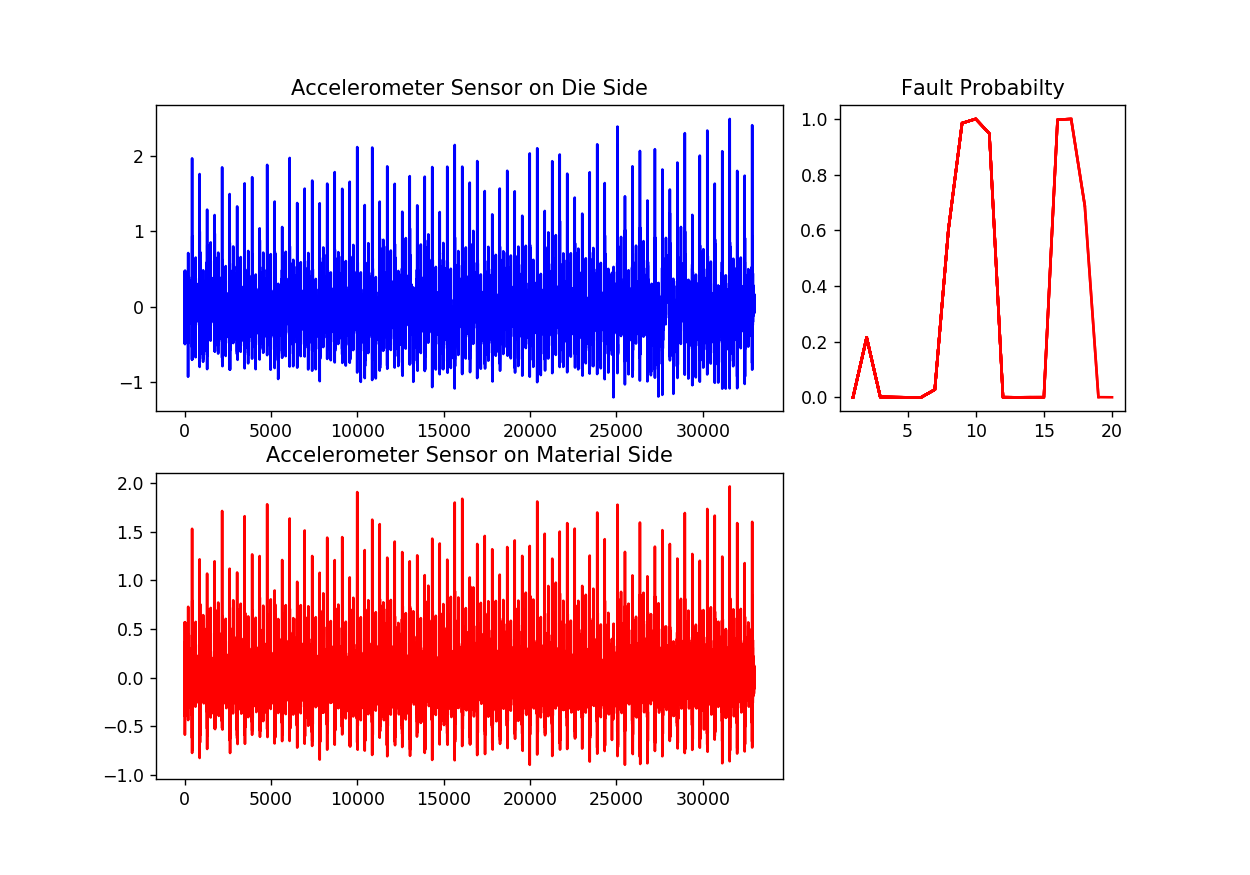

In [34]:
fig = plt.figure(figsize = (10, 7))

gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[1, :-1])
ax3 = fig.add_subplot(gs[0, -1])

i, i_n = 0, 0
scores = []
# while True:
while i <= (33000 - 1650):
    start_time = time.time()
    
    ax1.clear()
    ax2.clear()
    
    i += 1650
    x = np.linspace(1, i, i)
#     x = [i for i in range(1, i + 1)]
    
    ax1.set_title('Accelerometer Sensor on Die Side')
    ax1.plot(x, Data[0: i, 0], color = 'b')
    ax2.set_title('Accelerometer Sensor on Material Side')
    ax2.plot(x, Data[0: i, 1], color = 'r')
    
    data_wt = Preprocessing(Data[i_n*1650 : (i_n+1)*1650])
    GB_sem_AB_model.Inference(data_wt)
    scores.append(GB_sem_AB_model.score[0, 1])
    
    i_n += 1
    x_n = np.linspace(1, i_n, i_n)
    
    ax3.set_title('Fault Probabilty')
    ax3.plot(x_n, scores, color = 'r')
    
    fig.canvas.draw()
    
    time_taken = time.time() - start_time
#     print(Sec_to_M_S_ms(time_taken))
    time.sleep(1 - time_taken)
    
    
   

In [35]:
scores

[0.0006169898,
 0.2149357,
 0.0015244568,
 0.00084416853,
 0.00044430513,
 0.00050244975,
 0.028204095,
 0.6034692,
 0.98460126,
 0.9997008,
 0.94720024,
 0.0008878235,
 0.00044571393,
 0.00071495236,
 0.0008053059,
 0.996669,
 0.9997743,
 0.6886747,
 0.0010847425,
 0.00056147546]

In [21]:
scores[0][0, 1]

0.0006169898

In [26]:
i_n

20

In [40]:
np.arange(0, 333000, 1650).astype('uint32')

array([     0,   1650,   3300,   4950,   6600,   8250,   9900,  11550,
        13200,  14850,  16500,  18150,  19800,  21450,  23100,  24750,
        26400,  28050,  29700,  31350,  33000,  34650,  36300,  37950,
        39600,  41250,  42900,  44550,  46200,  47850,  49500,  51150,
        52800,  54450,  56100,  57750,  59400,  61050,  62700,  64350,
        66000,  67650,  69300,  70950,  72600,  74250,  75900,  77550,
        79200,  80850,  82500,  84150,  85800,  87450,  89100,  90750,
        92400,  94050,  95700,  97350,  99000, 100650, 102300, 103950,
       105600, 107250, 108900, 110550, 112200, 113850, 115500, 117150,
       118800, 120450, 122100, 123750, 125400, 127050, 128700, 130350,
       132000, 133650, 135300, 136950, 138600, 140250, 141900, 143550,
       145200, 146850, 148500, 150150, 151800, 153450, 155100, 156750,
       158400, 160050, 161700, 163350, 165000, 166650, 168300, 169950,
       171600, 173250, 174900, 176550, 178200, 179850, 181500, 183150,
      

In [28]:
GB_sem_AB_model.Inference(data_wt)
GB_sem_AB_model.score

array([[9.993830e-01, 6.169898e-04]], dtype=float32)

In [29]:
GB_sem_AB_model.pred

[0]

In [ ]:
data_wt = Preprocessing(Data[i_n*1650 : (i_n+1)*1650])
GB_sem_AB_model.Inference(data_wt)